In [2]:
from accelerate import Accelerator
import numpy as np
import torch
from models.mae_with_hemisphere_embed_and_diff_dim_per_area import MAE_with_region_stitcher
from utils.config_utils import config_from_kwargs, update_config
from utils.utils import set_seed, move_batch_to_device
from loader.data_loader_unbalanced_lump_short_list import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pickle
from tqdm import tqdm

In [3]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 12
mpl.rcParams['font.family'] = 'DejaVu Sans'
figure_path = '/work/hdd/bdye/jxia4/results/figures/'

In [4]:
session_order = pickle.load(open("/work/hdd/bdye/jxia4/data/tables_and_infos/session_order.pkl", 'rb'))
eids = [int(x) for x in np.sort(session_order[:40])]

In [5]:
base_path = '/work/hdd/bdye/jxia4/results/mae_results/'
num_train_sessions = len(eids)

mask_mode = 'region'

region_channel_num_encoder = 48 # number of region channels in encoder
unit_embed_dim = 50
n_layers = 5
consistency = True
include_opto = False

num_epochs = 1000
batch_size = 16
use_wandb = False

kwargs = {
    "model": f"include:/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/mae_with_hemisphere_embed_and_diff_dim_per_area.yaml",
}

config = config_from_kwargs(kwargs)
config = update_config("/work/hdd/bdye/jxia4/code/autoencoder_mae/src/configs/finetune_sessions_trainer.yaml", config)

config['model']['encoder']['masker']['mask_mode'] = mask_mode
config['model']['encoder']['stitcher']['n_channels_per_region'] = region_channel_num_encoder
config['model']['encoder']['stitcher']['unit_embed_dim'] = unit_embed_dim
config['training']['num_epochs'] = num_epochs
config['wandb']['use'] = use_wandb

meta_data = {}

  
dataloader, num_neurons, datasets, areaoi_ind, area_ind_list_list, heldout_info_list, trial_type_dict = make_loader(eids, batch_size, include_opto=include_opto, seed=config.seed)
set_seed(config.seed) 

print(trial_type_dict)

meta_data['area_ind_list_list'] = area_ind_list_list
meta_data['areaoi_ind'] = areaoi_ind
meta_data['num_sessions'] = len(eids)
meta_data['eids'] = eids

pr_max_dict_path = '/work/hdd/bdye/jxia4/data/tables_and_infos/pr_max_dict.pkl'
with open(pr_max_dict_path, 'rb') as f:
    pr_max_dict = pickle.load(f)

for k, v in pr_max_dict.items():
    pr_max_dict[k] = int(v)

meta_data['pr_max_dict'] = pr_max_dict

trial_type_values = list(trial_type_dict.values())
meta_data['trial_type_values'] = trial_type_values

config = update_config(config, meta_data) # so that everything is saved in the config file
test_dataloader = dataloader['test']

accelerator = Accelerator()


0
1
3
4
5
8
9
12
16
17
19
23
24
25
27
28
29
30
31
32
33
34
37
39
40
42
44
80
84
105
107
109
128
146
161
163
168
169
171
172


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


num_neurons:  [289, 193, 278, 339, 281, 186, 96, 220, 182, 277, 239, 140, 351, 145, 425, 274, 269, 253, 251, 256, 212, 239, 173, 355, 345, 271, 271, 185, 96, 223, 169, 318, 352, 179, 231, 150, 97, 116, 313, 173]
num_trials:  {'train': [156, 202, 243, 262, 258, 258, 248, 240, 273, 180, 206, 264, 184, 288, 187, 219, 211, 297, 275, 309, 262, 291, 228, 276, 319, 222, 231, 177, 199, 219, 191, 198, 243, 186, 205, 199, 236, 198, 252, 169], 'val': [52, 67, 81, 88, 86, 86, 83, 80, 91, 60, 69, 88, 62, 96, 62, 73, 70, 99, 92, 103, 88, 97, 76, 92, 106, 74, 77, 59, 66, 73, 64, 66, 81, 62, 68, 67, 79, 66, 84, 56], 'test': [53, 68, 81, 88, 86, 86, 83, 80, 92, 61, 69, 89, 62, 96, 63, 74, 71, 100, 92, 104, 88, 98, 76, 93, 107, 74, 78, 60, 67, 73, 64, 67, 81, 63, 69, 67, 79, 66, 85, 57]}
Succesfully constructing the dataloader for  train
Succesfully constructing the dataloader for  val
Succesfully constructing the dataloader for  test
seed set to 42
{'hit_left': 0, 'opto_early_4_hit_left': 1, 'opto_late

In [6]:
print('start loading model...')
consistency = True
#with_reg = True
num_train_sessions = 40

model_path = f'{base_path}train/svoboda_lump_short_list_wo_trial_type_embed/include_opto_{include_opto}/consistency_{consistency}/n_layers_{n_layers}/encoder_factors_{region_channel_num_encoder}/unit_embed_dim_{unit_embed_dim}/num_session_{num_train_sessions}/model_best.pt'
model = MAE_with_region_stitcher(config.model, **meta_data)
state_dict = torch.load(model_path)['model']
model.load_state_dict(state_dict)
model = accelerator.prepare(model)
model.eval()

start loading model...


/tmp/ipykernel_1249177/3216710116.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path)['model']


MAE_with_region_stitcher(
  (encoder): NeuralEncoder(
    (stitchers): NeuralStitcher_cross_att(
      (unit_embed_dict): ModuleDict(
        (0): Embedding(289, 50)
        (1): Embedding(193, 50)
        (3): Embedding(278, 50)
        (4): Embedding(339, 50)
        (5): Embedding(281, 50)
        (8): Embedding(186, 50)
        (9): Embedding(96, 50)
        (12): Embedding(220, 50)
        (16): Embedding(182, 50)
        (17): Embedding(277, 50)
        (19): Embedding(239, 50)
        (23): Embedding(140, 50)
        (24): Embedding(351, 50)
        (25): Embedding(145, 50)
        (27): Embedding(425, 50)
        (28): Embedding(274, 50)
        (29): Embedding(269, 50)
        (30): Embedding(253, 50)
        (31): Embedding(251, 50)
        (32): Embedding(256, 50)
        (33): Embedding(212, 50)
        (34): Embedding(239, 50)
        (37): Embedding(173, 50)
        (39): Embedding(355, 50)
        (40): Embedding(345, 50)
        (42): Embedding(271, 50)
        (44): Em

## Check inferred latent factors

In [7]:
encoder_latent = {}
for eid in eids:
    encoder_latent[eid] = {}

decoder_weights = {}
spike_data = {}
behavior_data = {}

set_seed(config.seed)
with torch.no_grad():
    for batch in test_dataloader:
        device = accelerator.device
        batch = move_batch_to_device(batch, device)
        B = batch['spikes_data'].size(0)
        T = batch['spikes_data'].size(1)
        eid = batch['eid'][0].item()
        print('eid', eid)
        neuron_regions = batch['neuron_regions'][0] #(N,) area_ind_list
        area_ind_unique_tensor = neuron_regions.unique()
        R = len(area_ind_unique_tensor) #number of regions

        #don't mask any data
        mask_T = torch.zeros([B,T], dtype=torch.bool, device=device)
        mask_R = torch.zeros([B,R], dtype=torch.bool, device=device)
        ids_restore_R = None
        ids_restore_T = None
        mask = torch.zeros([B,T,R], dtype=torch.bool, device=device)

        force_mask ={'mask': mask, 
                    'mask_R': mask_R, 
                    'mask_T': mask_T, 
                    'ids_restore_R': ids_restore_R, 
                    'ids_restore_T': ids_restore_T}

        area_ind_list_full = batch['neuron_regions_full'][0] # (N_all,) 

        x, mask, mask_R, mask_T, ids_restore_R, ids_restore_T = model.encoder(batch['spikes_data'], 
                                                                            batch['spikes_timestamps'],
                                                                            area_ind_unique_tensor, 
                                                                            batch['neuron_regions'],
                                                                            batch['is_left'],
                                                                            batch['trial_type'], 
                                                                            mask_mode, 
                                                                            batch['eid'][0], 
                                                                            force_mask)
        
        # Decode
        factors_pred_dict = {}
        for area_ind in areaoi_ind:
            x_tmp = x[:,:, areaoi_ind==area_ind,:].squeeze(dim=2) # (B, T, H)
            factors_pred_dict[str(area_ind)] = model.stitch_decoder.linear_layer_dict[str(area_ind)](x_tmp).detach().cpu().numpy() # (B, T, n_channels_this_region)

        trial_type = batch['trial_type']

        eid_ind = eids.index(eid)
        heldout_area_ind = heldout_info_list[eid_ind]['heldout_region_ind']
        encoder_latent[eid]['heldout_spikes'] = batch['spikes_data_full'][:,:,area_ind_list_full==heldout_area_ind].detach().cpu().numpy()
        
        encoder_latent[eid]['factors_pred'] = factors_pred_dict 
        encoder_latent[eid]['trial_type'] = trial_type.detach().cpu().numpy()
        encoder_latent[eid]['area_ind_unique'] = area_ind_unique_tensor.detach().cpu().numpy()
        encoder_latent[eid]['num_neurons'] = {}
        for area_ind in area_ind_unique_tensor:
            encoder_latent[eid]['num_neurons'][str(area_ind.item())] = (neuron_regions==area_ind).sum().item()

        decoder_weights[eid] = {}
        spike_data[eid] = {}
        for area_ind in area_ind_unique_tensor:
            decoder_weights[eid][str(area_ind.item())] = model.stitch_decoder.stitch_decoder_dict[str(eid)][str(area_ind.item())]
            spike_data[eid][str(area_ind.item())] = batch['spikes_data'][:,:,neuron_regions==area_ind].detach().cpu().numpy() # (B, T, # of neurons in this area)
        
        behavior_data[eid] = batch['target'].detach().cpu().numpy()
        # x = model.encoder.stitchers(batch['spikes_data'], str(batch['eid'][0].item()), batch['neuron_regions']) # (B, T, R, n_channels)
        # encoder_latent[eid]['embed_factor'] = {}
        # for id, area_ind in enumerate(area_ind_unique_tensor):
        #     encoder_latent[eid]['embed_factor'][str(area_ind.item())] = x[:,:,id,:].detach().cpu().numpy()

        


seed set to 42
eid 32
eid 29
eid 28
eid 44
eid 5
eid 24
eid 169
eid 80
eid 172
eid 9
eid 42
eid 17
eid 25
eid 109
eid 161
eid 16
eid 30
eid 40
eid 0
eid 146
eid 8
eid 23
eid 1
eid 105
eid 34
eid 3
eid 107
eid 168
eid 4
eid 163
eid 39
eid 128
eid 19
eid 37
eid 31
eid 33
eid 12
eid 27
eid 84
eid 171


In [8]:
path = '/work/hdd/bdye/jxia4/data/tables_and_infos/'

#load region_info_summary.pkl
with open(path + 'region_info_summary.pkl', 'rb') as f:
    [brain_region_list, session_by_region, session_by_region_n, junk] = pickle.load(f)

brain_region_list = np.append(brain_region_list, 'ALM') #add ALM to the list


In [9]:
brain_region_list_acronym = brain_region_list.copy()
brain_region_list_acronym[brain_region_list_acronym == 'Midbrain reticular nucleus'] = 'MRN'
brain_region_list_acronym[brain_region_list_acronym == 'Ventral anterior-lateral complex of the thalamus'] = 'VAL-VM'
brain_region_list_acronym[brain_region_list_acronym == 'Orbital area, lateral part, layer 1'] = 'lOrb'
brain_region_list_acronym[brain_region_list_acronym == 'Orbital area, ventrolateral part, layer 1'] = 'vlOrb'
brain_region_list_acronym[brain_region_list_acronym == 'Superior colliculus, motor related, deep gray layer'] = 'SC'

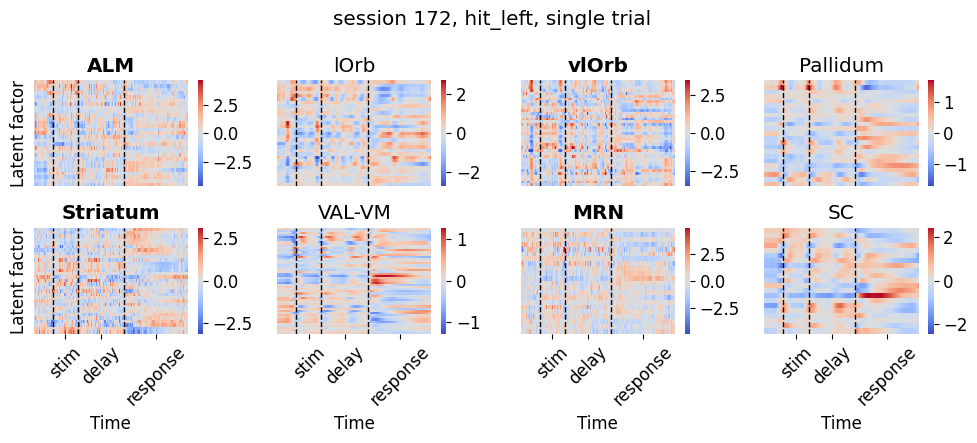

In [13]:
#to get the same order as in main plot using eids[5]; trial [1]; hit_left; to get the factor_order_dict
#plot inferred factors for all areas in one session
n_row = 2
n_col = 4

fig, ax = plt.subplots(n_row, n_col, figsize=(10, 4.5))
trial_type_key = 'hit_left'
trial_type_ind = trial_type_dict[trial_type_key]
eid = eids[-1]
plt.suptitle(f'session {eid}, {trial_type_key}, single trial')
trial_type = encoder_latent[eid]['trial_type']

if not trial_type_ind in trial_type:
    print('trial type not in session')
    exit()

trial_ind = np.where(trial_type == trial_type_ind)[0][1]

if 'factor_order_dict' not in globals():
    factor_order_dict = {}

for i in range(n_row):
    for j in range(n_col):
        plt.sca(ax[i,j])

        area_ind = areaoi_ind[i*n_col + j]
        factors_pred_region = encoder_latent[eid]['factors_pred'][str(area_ind)]
        factors_pred_region_tmp = factors_pred_region[trial_ind] - np.mean(factors_pred_region[trial_ind][:], axis=0, keepdims=True)

        if (area_ind not in factor_order_dict) and (trial_type_key == 'hit_left'):
            kmeans = KMeans(n_clusters=5, random_state=0).fit(factors_pred_region_tmp.T)
            factor_order = np.argsort(kmeans.labels_)
            factor_order_dict[area_ind] = factor_order

        vmax = np.max(factors_pred_region_tmp[:,factor_order_dict[area_ind]][:])
        vmin = np.min(factors_pred_region_tmp[:,factor_order_dict[area_ind]][:])

        sns.heatmap(factors_pred_region_tmp[:,factor_order_dict[area_ind]].T, cmap='coolwarm', vmax=vmax, vmin=-vmax)

        if i == n_row-1:
            plt.xlabel('Time')
            plt.xticks([50+65/2, 115+120/2, 235+165/2], ['stim', 'delay', 'response'], rotation=45)
        else:
            plt.xticks([])
        if j == 0:
            plt.ylabel('Latent factor')
        
        area_ind_unique = encoder_latent[eid]['area_ind_unique']
        if area_ind in area_ind_unique:
            ax[i,j].set_title(f'{brain_region_list_acronym[area_ind]}', fontweight='bold')
        else:
            ax[i,j].set_title(f'{brain_region_list_acronym[area_ind]}')
        
        ax[i,j].set_yticks([])

        plt.axvline(50, color='black', lw=1, ls='--')
        plt.axvline(50+65, color='black', lw=1, ls='--')
        plt.axvline(50+65+120, color='black', lw=1, ls='--')

plt.tight_layout()


In [14]:
from scipy.stats import spearmanr

#calculate RSA between behavior data and latent factors from each area. 

def calculate_RSA(x_list):
    '''
    calculate representation distance matrix

    x_list: a list of (T, n_factors), with n elements or an array of (n, T, n_factors), e.g. n is number of areas
    return RSA: n x n

    '''

    n = len(x_list)
    rdm_list = []
    for i in range(n):    
       rdm_list.append(1-np.corrcoef(x_list[i]))
    
    rsa = np.zeros([n, n])*np.nan
    for i in range(n):
        for j in range(i+1,n):
            tmp_i = rdm_list[i][np.triu_indices(rdm_list[i].shape[0], k=1)]
            tmp_j = rdm_list[j][np.triu_indices(rdm_list[j].shape[0], k=1)]

            rsa[i,j] = spearmanr(tmp_i, tmp_j).correlation

    return rsa



In [15]:
rsa_dict = {}

In [31]:
trial_type_key = 'hit_left'
trial_type_ind = trial_type_dict[trial_type_key]

rsa_dict[trial_type_key] = {}

for eid in tqdm(eids):
    trial_type = encoder_latent[eid]['trial_type']

    if not trial_type_ind in trial_type:
        print('trial type not in session')
        exit()

    trial_ind_list = np.where(trial_type == trial_type_ind)[0]
    n_trials = len(trial_ind_list)
    #rsa_list = np.zeros([n_trials, len(areaoi_ind)+1, len(areaoi_ind)+1])*np.nan
    rsa_list = np.zeros([n_trials, len(areaoi_ind), len(areaoi_ind)])*np.nan

    for ind, trial_ind in enumerate(trial_ind_list):
        x_list = []

        for area_ind in areaoi_ind:
            factors_pred_region = encoder_latent[eid]['factors_pred'][str(area_ind)][trial_ind,:,:]
            factors_pred_region = factors_pred_region - np.mean(factors_pred_region[:], axis=0, keepdims=True)
            #x_list.append(factors_pred_region[235:]) #response period only
            #x_list.append(factors_pred_region[50:115]) #stim period only
            x_list.append(factors_pred_region[115:235]) #delay period only

        rsa = calculate_RSA(x_list)
        rsa_list[ind] = rsa

    rsa_dict[trial_type_key][eid] = rsa_list


100%|██████████| 40/40 [00:32<00:00,  1.22it/s]


/tmp/ipykernel_1249177/1873798884.py:7: RuntimeWarning: Mean of empty slice
  rsa_trial_avg = np.nanmean(rsa_dict[trial_type_key][eid], axis=0)
/tmp/ipykernel_1249177/1873798884.py:11: RuntimeWarning: Mean of empty slice
  rsa_session_mean = np.nanmean(rsa_session_list, axis=0)
/u/jxia4/.conda/envs/svo-mae/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


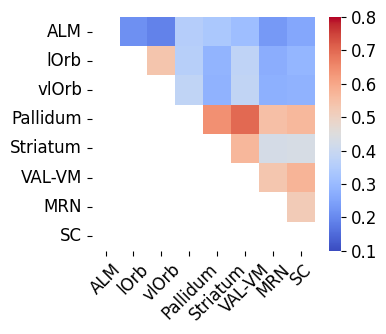

In [32]:
#plot trial-avg session-avg RSA 

trial_type_key = 'hit_left'

rsa_session_list = []
for eid in eids:
    rsa_trial_avg = np.nanmean(rsa_dict[trial_type_key][eid], axis=0)
    rsa_session_list.append(rsa_trial_avg)

rsa_session_list = np.array(rsa_session_list)
rsa_session_mean = np.nanmean(rsa_session_list, axis=0)
rsa_session_std = np.nanstd(rsa_session_list, axis=0)

plt.figure(figsize=(4, 3.5))
sns.heatmap(rsa_session_mean,cmap='coolwarm', vmax=0.8, vmin=0.1)
plt.xticks(np.arange(len(areaoi_ind))+0.5, brain_region_list_acronym[areaoi_ind], rotation=45)
plt.yticks(np.arange(len(areaoi_ind))+0.5, brain_region_list_acronym[areaoi_ind], rotation=0)
plt.tight_layout()


### plot inferred latent factors for each area

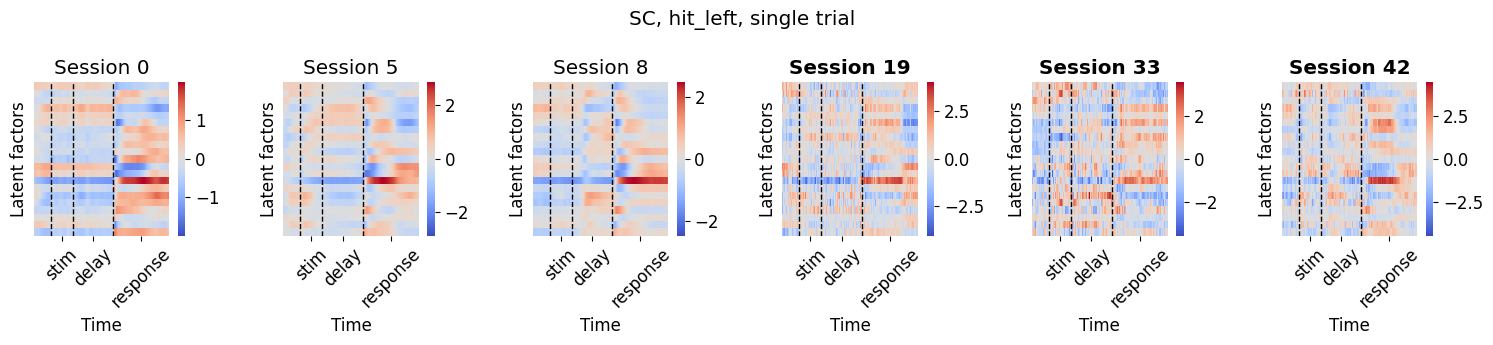

In [24]:
# plot inferred factors in ALM across sessions
area_ind = areaoi_ind[7]
n_row = 1
n_col = 6
fig, ax = plt.subplots(n_row, n_col, figsize=(15, 3.5))
trial_type_key = 'hit_left'
trial_type_ind = trial_type_dict[trial_type_key]

factor_order = factor_order_dict[area_ind] 
eids = np.array(eids)

for i in range(n_row):
    for j in range(n_col):
        if i*n_col + j >= num_train_sessions:

            plt.sca(ax[j])
            plt.axis('off')

            break
        eid = eids[[0,4,5,10,20,25]][i*n_col + j]
        factors_pred_region = encoder_latent[eid]['factors_pred'][str(area_ind)]
        trial_type = encoder_latent[eid]['trial_type']

        if not trial_type_ind in trial_type:
            continue

        trial_ind = np.where(trial_type == trial_type_ind)[0][-1]
        #print(trial_ind)
        plt.sca(ax[j])

        factors_pred_region_tmp = factors_pred_region[trial_ind] - np.mean(factors_pred_region[trial_ind][:], axis=0, keepdims=True)

        vmax = np.max(factors_pred_region_tmp[:,factor_order_dict[area_ind]][:])
        vmin = np.min(factors_pred_region_tmp[:,factor_order_dict[area_ind]][:])

        sns.heatmap(factors_pred_region_tmp[:,factor_order].T, cmap='coolwarm', vmax=vmax, vmin=-vmax)
        plt.xlabel('Time')
        plt.ylabel('Latent factors')

        area_ind_unique = encoder_latent[eid]['area_ind_unique']
        if area_ind in area_ind_unique:
            ax[j].set_title('Session %d'%(eid), fontweight='bold')
        else:
            ax[j].set_title('Session %d'%(eid))

        ax[j].set_xticks([50+65/2, 115+120/2, 235+165/2], ['stim', 'delay', 'response'], rotation=45)
        ax[j].set_yticks([])

        plt.axvline(50, color='black', lw=1, ls='--')
        plt.axvline(50+65, color='black', lw=1, ls='--')
        plt.axvline(50+65+120, color='black', lw=1, ls='--')



plt.suptitle(f'{brain_region_list_acronym[area_ind]}, {trial_type_key}, single trial')
plt.tight_layout()
#plt.savefig(figure_path+f'fig4/{brain_region_list_acronym[area_ind]}_{trial_type_key}_single_trial_across_session.pdf', transparent=True)


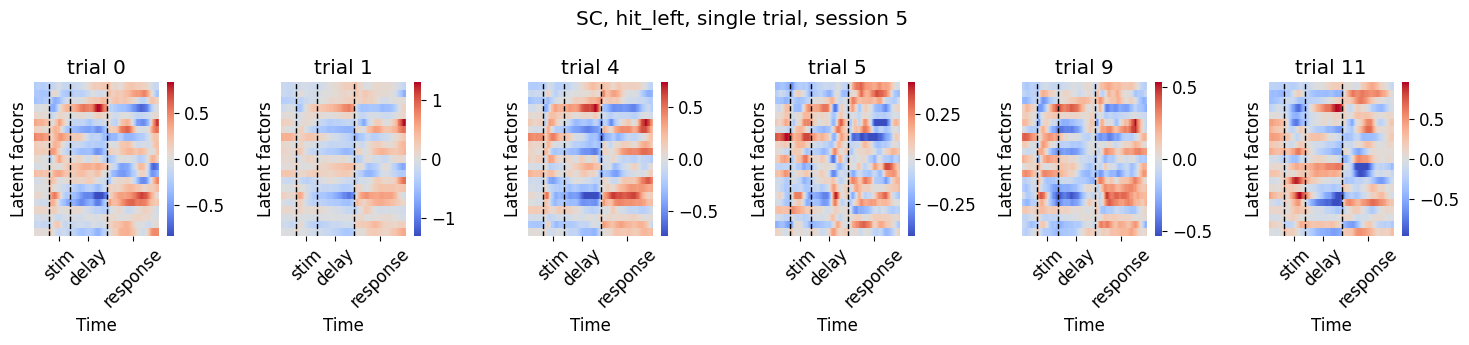

In [25]:
# plot inferred factors in ALM across trials
area_ind = areaoi_ind[7]
n_row = 1
n_col = 6
fig, ax = plt.subplots(n_row, n_col, figsize=(15, 3.5))
trial_type_key = 'hit_left'
trial_type_ind = trial_type_dict[trial_type_key]

eid_ind = 4

factor_order = factor_order_dict[area_ind] 

eid = eids[eid_ind]
factors_pred_region = encoder_latent[eid]['factors_pred'][str(area_ind)]
trial_type = encoder_latent[eid]['trial_type']
trial_ind_list = np.where(trial_type == trial_type_ind)[0]

trial_ind_left = np.where(trial_type == 0)[0]
trial_ind_right = np.where(trial_type == 21)[0]
trial_ind_hit = np.concatenate([trial_ind_left, trial_ind_right])

tmp_trial_avg = np.mean(factors_pred_region[trial_ind_hit], axis=0)
 


for i in range(n_row):
    for j in range(n_col):
        if i*n_col + j >= len(trial_ind_list):
            break

        if not trial_type_ind in trial_type:
            continue

        trial_ind = trial_ind_list[i*n_col+j]
        #print(trial_ind)
        plt.sca(ax[j])

        tmp1 = factors_pred_region[trial_ind]- tmp_trial_avg
        factors_pred_region_tmp = tmp1 - np.mean(tmp1, axis=0, keepdims=True)
        #factors_pred_region_tmp = factors_pred_region[trial_ind] - np.mean(factors_pred_region[trial_ind][:], axis=0, keepdims=True)



        vmax = np.max(factors_pred_region_tmp)
        vmin = np.min(factors_pred_region_tmp)

        sns.heatmap(factors_pred_region_tmp[:,factor_order].T, cmap='coolwarm', vmax=vmax, vmin=-vmax)
        plt.xlabel('Time')
        plt.ylabel('Latent factors')

        area_ind_unique = encoder_latent[eid]['area_ind_unique']
        if area_ind in area_ind_unique:
            ax[j].set_title('trial %d'%(trial_ind), fontweight='bold')
        else:
            ax[j].set_title('trial %d'%(trial_ind))

        ax[j].set_yticks([])

        plt.axvline(50, color='black', lw=1, ls='--')
        plt.axvline(50+65, color='black', lw=1, ls='--')
        plt.axvline(50+65+120, color='black', lw=1, ls='--')
    
        ax[j].set_xticks([50+65/2, 115+120/2, 235+165/2], ['stim', 'delay', 'response'], rotation=45)

plt.suptitle(f'{brain_region_list_acronym[area_ind]}, {trial_type_key}, single trial, session {eids[eid_ind]}')
plt.tight_layout()

#plt.savefig(figure_path+f'fig4/{brain_region_list_acronym[area_ind]}_{trial_type_key}_single_trial_across_trials_session_{eid}_substract_hit_trial_avg.pdf', transparent=True)